<a href="https://colab.research.google.com/github/Daudi232/DS_3/blob/main/Thesis/Segmentation/Segmentation_Unet_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INFO

This notebook experiments with the unet architecture in collaboration with the use of vgg model for feature extraction.

Part 1 is boiler-plate code including functions used in different parts

Parts 2-5 include different variations of the unet model. They were run separately and combined here for organization sake.

# PART 1: BOILER-PLATE

## Drive Config

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import kagglehub
import os
import pandas as pd
import PIL
from skimage import io

## Helper functions

### Training Loop

#### without early stopping

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def train_segmentation_model(model, train_data_loader, val_data_loader, optimizer, loss_fn, save_path, epochs=30, device='cpu'):

    model.to(device)

    history = {'Training': {'Loss': [], 'Pixel Accuracy': []},
               'Validation': {'Loss': [], 'Pixel Accuracy': []}}

    best_val_loss = np.inf

    for epoch in range(1, epochs + 1):

        # --- TRAIN ---
        model.train()
        train_loss = 0
        correct_pixels_train = 0
        total_pixels_train = 0

        for batch, target in train_data_loader:
            input = batch.to(device)
            # Semantic segmentation targets must be Long (integers) for CrossEntropy
            target = target.to(device) # they are already long in the data pipeline
            # target = target.to(device).long()

            # If target has a channel dimension (B, 1, H, W), squeeze it to (B, H, W)
            # if target.dim() == 4:
                # target = target.squeeze(1)

            output = model(input)
            #outputs are logits

            # Output: (B, Num_Classes, H, W), Target: (B, H, W)
            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Pixel-wise Accuracy
            # argmax along channel dimension (dim=1) gives the predicted class map
            predicted_mask = output.argmax(dim=1)
            correct_pixels_train += (predicted_mask == target).sum().item()
            total_pixels_train += target.numel() # Count total pixels in the batch #???

        train_loss /= len(train_data_loader)
        # Divide correct pixels by TOTAL pixels, not total images
        train_acc = correct_pixels_train / total_pixels_train

        history['Training']['Loss'].append(train_loss)
        history['Training']['Pixel Accuracy'].append(train_acc)

        # --- EVALUATE ---
        model.eval()
        val_loss = 0
        correct_pixels_val = 0
        total_pixels_val = 0

        with torch.no_grad():
            for batch, target in val_data_loader:
                input = batch.to(device)
                target = target.to(device).long()

                # if target.dim() == 4:
                #     target = target.squeeze(1)

                output = model(input)
                loss = loss_fn(output, target)

                val_loss += loss.item()

                predicted_mask = output.argmax(dim=1)
                correct_pixels_val += (predicted_mask == target).sum().item()
                total_pixels_val += target.numel()

        val_loss /= len(val_data_loader)
        val_acc = correct_pixels_val / total_pixels_val

        history['Validation']['Loss'].append(val_loss)
        history['Validation']['Pixel Accuracy'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path) # It's generally better to save state_dict
            print(f"Saved model at epoch {epoch} with Val Loss: {val_loss:.4f}")

        print(f"Epoch: [{epoch}/{epochs}]\t Train Loss: {train_loss:.4f}\t Val Loss: {val_loss:.4f}\t Val Pixel Acc: {val_acc:.4f}")

    return history

#### with early stopping

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def train_segmentation_model_es(model, train_data_loader, val_data_loader, optimizer, loss_fn, save_path, patience = 5, epochs=30, device='cpu'):

    model.to(device)

    history = {'Training': {'Loss': [], 'Pixel Accuracy': []},
               'Validation': {'Loss': [], 'Pixel Accuracy': []}}

    best_val_loss = np.inf
    counter = 0

    for epoch in range(1, epochs + 1):

        # --- TRAIN ---
        model.train()
        train_loss = 0
        correct_pixels_train = 0
        total_pixels_train = 0

        for batch, target in train_data_loader:
            input = batch.to(device)
            # Semantic segmentation targets must be Long (integers) for CrossEntropy
            target = target.to(device) # they are already long in the data pipeline
            # target = target.to(device).long()

            # If target has a channel dimension (B, 1, H, W), squeeze it to (B, H, W)
            # if target.dim() == 4:
                # target = target.squeeze(1)

            output = model(input)
            #outputs are logits

            # Output: (B, Num_Classes, H, W), Target: (B, H, W)
            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Pixel-wise Accuracy
            # argmax along channel dimension (dim=1) gives the predicted class map
            predicted_mask = output.argmax(dim=1)
            correct_pixels_train += (predicted_mask == target).sum().item()
            total_pixels_train += target.numel() # Count total pixels in the batch #???

        train_loss /= len(train_data_loader)
        # Divide correct pixels by TOTAL pixels, not total images
        train_acc = correct_pixels_train / total_pixels_train

        history['Training']['Loss'].append(train_loss)
        history['Training']['Pixel Accuracy'].append(train_acc)

        # --- EVALUATE ---
        model.eval()
        val_loss = 0
        correct_pixels_val = 0
        total_pixels_val = 0

        with torch.no_grad():
            for batch, target in val_data_loader:
                input = batch.to(device)
                target = target.to(device).long()

                # if target.dim() == 4:
                #     target = target.squeeze(1)

                output = model(input)
                loss = loss_fn(output, target)

                val_loss += loss.item()

                predicted_mask = output.argmax(dim=1)
                correct_pixels_val += (predicted_mask == target).sum().item()
                total_pixels_val += target.numel()

        val_loss /= len(val_data_loader)
        val_acc = correct_pixels_val / total_pixels_val

        history['Validation']['Loss'].append(val_loss)
        history['Validation']['Pixel Accuracy'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path) # It's generally better to save state_dict
            print(f"Saved model at epoch {epoch} with Val Loss: {val_loss:.4f}")

            counter = 0

        else: counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        print(f"Epoch: [{epoch}/{epochs}]\t Train Loss: {train_loss:.4f}\t Val Loss: {val_loss:.4f}\t Val Pixel Acc: {val_acc:.4f}")

    return history

#### with dice loss

In [ ]:
def train_segmentation_model_es_dice(model, train_data_loader, val_data_loader, optimizer, loss_fn_ce, save_path, patience=5, epochs=30, device='cpu'):

    model.to(device)

    # Initialize the new Dice Loss
    loss_fn_dice = DiceLoss().to(device)

    history = {'Training': {'Loss': [], 'Pixel Accuracy': []},
               'Validation': {'Loss': [], 'Pixel Accuracy': []}}

    best_val_loss = np.inf
    counter = 0

    for epoch in range(1, epochs + 1):
        # --- TRAIN ---
        model.train()
        train_loss = 0
        correct_pixels_train = 0
        total_pixels_train = 0

        for batch, target in train_data_loader:
            input = batch.to(device)
            target = target.to(device).long() # Ensure target is Long

            output = model(input) # Output is (B, 2, H, W)

            # --- CHANGED HERE: Combined Loss ---
            ce_loss = loss_fn_ce(output, target)
            dice_loss = loss_fn_dice(output, target)

            # You can weight them if needed, e.g., 0.5 * ce + 0.5 * dice
            # But usually 1:1 works well for standard U-Nets
            loss = ce_loss + dice_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted_mask = output.argmax(dim=1)
            correct_pixels_train += (predicted_mask == target).sum().item()
            total_pixels_train += target.numel()

        train_loss /= len(train_data_loader)
        train_acc = correct_pixels_train / total_pixels_train

        history['Training']['Loss'].append(train_loss)
        history['Training']['Pixel Accuracy'].append(train_acc)

        # --- EVALUATE ---
        model.eval()
        val_loss = 0
        correct_pixels_val = 0
        total_pixels_val = 0

        with torch.no_grad():
            for batch, target in val_data_loader:
                input = batch.to(device)
                target = target.to(device).long()

                output = model(input)

                # Calculate validation loss with the same combined metric
                ce_loss = loss_fn_ce(output, target)
                dice_loss = loss_fn_dice(output, target)
                loss = ce_loss + dice_loss

                val_loss += loss.item()

                predicted_mask = output.argmax(dim=1)
                correct_pixels_val += (predicted_mask == target).sum().item()
                total_pixels_val += target.numel()

        val_loss /= len(val_data_loader)
        val_acc = correct_pixels_val / total_pixels_val

        history['Validation']['Loss'].append(val_loss)
        history['Validation']['Pixel Accuracy'].append(val_acc)

        # Save and Early Stopping logic remains the same...
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Saved model at epoch {epoch} with Val Loss: {val_loss:.4f}")
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        print(f"Epoch: [{epoch}/{epochs}]\t Train Loss: {train_loss:.4f}\t Val Loss: {val_loss:.4f}\t Val Pixel Acc: {val_acc:.4f}")

    return history

#### with LR scheduler

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torch

def train_es_lr_dice(model, train_data_loader, val_data_loader, optimizer, loss_fn_ce, save_path, patience_es=10, epochs=30, device='cpu'):

    model.to(device)

    # Initialize the new Dice Loss (assuming DiceLoss class is already defined)
    loss_fn_dice = DiceLoss().to(device)

    # Scheduler: Monitors validation loss
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    history = {'Training': {'Loss': [], 'Pixel Accuracy': [], 'Dice Score': []},
               'Validation': {'Loss': [], 'Pixel Accuracy': [], 'Dice Score': []}}

    best_val_loss = np.inf
    counter = 0

    for epoch in range(1, epochs + 1):
        # --- TRAIN ---
        model.train()
        train_loss = 0
        train_dice_sum = 0
        correct_pixels_train = 0
        total_pixels_train = 0

        for batch, target in train_data_loader:
            input = batch.to(device)
            target = target.to(device).long() # Ensure target is Long

            output = model(input) # Output is (B, 2, H, W)

            # Combined Loss
            ce_loss = loss_fn_ce(output, target)
            dice_loss = loss_fn_dice(output, target)
            loss = ce_loss + dice_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Track Dice Score (1 - Dice Loss)
            dice_score = 1 - dice_loss.item()
            train_dice_sum += dice_score

            predicted_mask = output.argmax(dim=1)
            correct_pixels_train += (predicted_mask == target).sum().item()
            total_pixels_train += target.numel()

        # Calculate Training Averages
        train_loss_avg = train_loss / len(train_data_loader)
        train_dice_avg = train_dice_sum / len(train_data_loader)
        train_acc = correct_pixels_train / total_pixels_train

        history['Training']['Loss'].append(train_loss_avg)
        history['Training']['Pixel Accuracy'].append(train_acc)
        history['Training']['Dice Score'].append(train_dice_avg)

        # --- EVALUATE ---
        model.eval()
        val_loss = 0
        val_dice_sum = 0
        correct_pixels_val = 0
        total_pixels_val = 0

        with torch.no_grad():
            for batch, target in val_data_loader:
                input = batch.to(device)
                target = target.to(device).long()

                output = model(input)

                # Validation Loss
                ce_loss = loss_fn_ce(output, target)
                dice_loss = loss_fn_dice(output, target)
                loss = ce_loss + dice_loss

                val_loss += loss.item()

                # Validation Dice
                dice_score_val = 1 - dice_loss.item()
                val_dice_sum += dice_score_val

                predicted_mask = output.argmax(dim=1)
                correct_pixels_val += (predicted_mask == target).sum().item()
                total_pixels_val += target.numel()

        # 1. Calculate Validation Averages FIRST
        val_loss_avg = val_loss / len(val_data_loader)
        val_dice_avg = val_dice_sum / len(val_data_loader)
        val_acc = correct_pixels_val / total_pixels_val

        # 2. Step the Scheduler (using the Average Loss)
        scheduler.step(val_loss_avg)

        history['Validation']['Loss'].append(val_loss_avg)
        history['Validation']['Pixel Accuracy'].append(val_acc)
        history['Validation']['Dice Score'].append(val_dice_avg)

        # 3. Checkpointing & Early Stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            torch.save(model.state_dict(), save_path)
            print(f"Saved model at epoch {epoch} with Val Loss: {val_loss_avg:.4f}")
            counter = 0
        else:
            counter += 1

        if counter >= patience_es:
            print(f"Early stopping triggered at epoch {epoch}")
            break

        print(f"Epoch: [{epoch}/{epochs}]\t Train Loss: {train_loss_avg:.4f}\t Dice: {train_dice_avg:.4f}\t Val Loss: {val_loss_avg:.4f}\t Val Acc: {val_acc:.4f}\t Val Dice: {val_dice_avg:.4f}")

    return history

### Database setup function

In [ ]:
def database_setup(root_dir):

  print('Creating folders')
  import os
  import shutil

  folders = ['train', 'test', 'val']
  subfolders = ['images', 'masks']

  for folder in folders:
    for subfolder in subfolders:
      if not os.path.exists(os.path.join(folder, subfolder)):
        os.makedirs(os.path.join(folder, subfolder))

  # Creates a list of images and masks, sorted in accordance to the dog/cat name
  im_path = os.path.join(root_dir, 'Chest-X-Ray', 'Chest-X-Ray', 'image')
  mask_path = os.path.join(root_dir, 'Chest-X-Ray', 'Chest-X-Ray', 'mask')

  im_dir_ls = os.listdir(im_path)
  mask_dir_ls = os.listdir(mask_path)

  im_ls = []
  mask_ls = []

  # the second condition is because of the hidden files
  for i in im_dir_ls:
    if i.endswith('png') and not i.startswith('.'):
      im_ls.append(i)

  for i in mask_dir_ls:
    if i.endswith('png') and not i.startswith('.'):
      mask_ls.append(i)

  print(f'Images found: {len(im_ls)}')
  print(f'Masks found: {len(mask_ls)}')

  # introduce randomness which is useful for splitting
  import random

  random.Random(7).shuffle(im_ls)
  random.Random(7).shuffle(mask_ls)

  # sort so that the image and mask match
  im_ls = sorted(im_ls)
  mask_ls = sorted(mask_ls)

  # visualize an image and it's mask
  from skimage import io
  import matplotlib.pyplot as plt

  img = io.imread(os.path.join(im_path, im_ls[0]))
  mask = io.imread(os.path.join(mask_path, mask_ls[0]))

  fig, ax = plt.subplots(1, 2, figsize = (10, 5))

  ax[0].imshow(img, cmap = 'gray');
  ax[1].imshow(mask, cmap = 'gray');
  ax[0].set_title('Image');
  ax[1].set_title('Mask');

  # Divide the dataset to their directories
  import shutil

  train_ratio = 0.8
  val_ratio = 0.1
  test_ratio = 0.1
  size = len(im_ls)

  train_size = int(size * train_ratio)
  val_size = int(size * val_ratio)
  test_size = int(size * test_ratio)

  train_im_ls = im_ls[:train_size]
  val_im_ls = im_ls[train_size: train_size + val_size + 1]
  test_im_ls = im_ls[train_size + val_size + 1:]

  train_mask_ls = mask_ls[:train_size]
  val_mask_ls = mask_ls[train_size:train_size + val_size + 1]
  test_mask_ls = mask_ls[train_size + val_size + 1:]

  print('Dividing dataset to directories')
  for img in train_im_ls:
    shutil.copy(os.path.join(im_path, img), os.path.join('train', 'images'))

  for mask in train_mask_ls:
    shutil.copy(os.path.join(mask_path, mask), os.path.join('train', 'masks'))

  for img in val_im_ls:
    shutil.copy(os.path.join(im_path, img), os.path.join('val', 'images'))

  for mask in val_mask_ls:
    shutil.copy(os.path.join(mask_path, mask), os.path.join('val', 'masks'))

  for img in test_im_ls:
    shutil.copy(os.path.join(im_path, img), os.path.join('test', 'images'))

  for mask in test_mask_ls:
    shutil.copy(os.path.join(mask_path, mask), os.path.join('test', 'masks'))

  print('Done')

  return im_ls, mask_ls

## Dataset Downloading

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

print("Path to dataset files:", path)

100%|██████████| 3.59G/3.59G [00:34<00:00, 112MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamtapendu/chest-x-ray-lungs-segmentation/versions/1


### Structure of the dataset

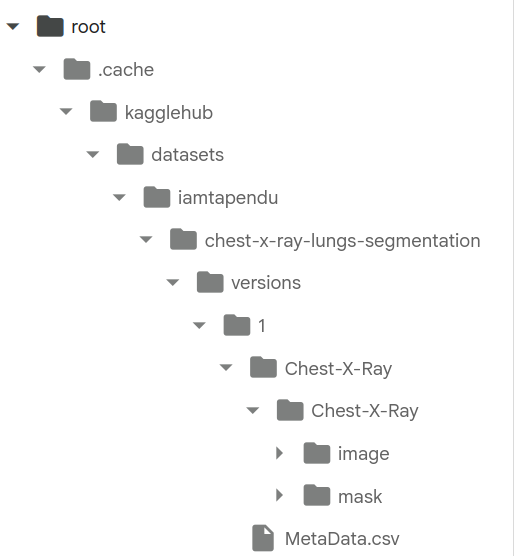

In [ ]:
import os
import pandas as pd

im_path = os.path.join(path, 'Chest-X-Ray', 'Chest-X-Ray', 'image')
mask_path = os.path.join(path, 'Chest-X-Ray', 'Chest-X-Ray', 'mask')
im_ls = os.listdir(im_path)
mask_ls = os.listdir(mask_path)

print(im_ls[:5])
print(mask_ls[:5])

print(len(im_ls))
print(len(mask_ls))

['1589.png', '1513.png', '1678.png', '1476.png', '1697.png']
['1589.png', '1513.png', '1678.png', '1476.png', '1697.png']
704
704


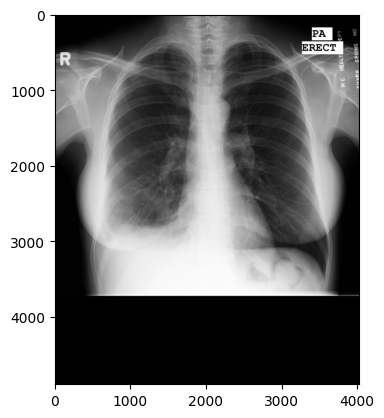

In [ ]:
import matplotlib.pyplot as plt

img = io.imread(os.path.join(im_path, im_ls[0]))

plt.imshow(img, cmap = 'gray');

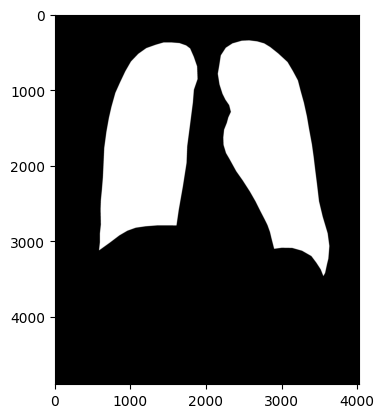

In [ ]:
import matplotlib.pyplot as plt

mask = io.imread(os.path.join(mask_path, mask_ls[0]))

plt.imshow(mask, cmap = 'gray');

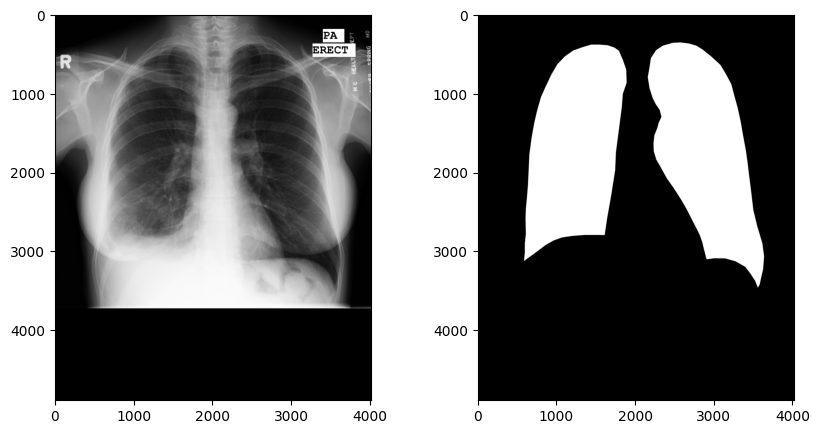

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(img, cmap = 'gray');
ax[1].imshow(mask, cmap = 'gray');

### Database setup

Creating folders
Images found: 704
Masks found: 704
Dividing dataset to directories
Done


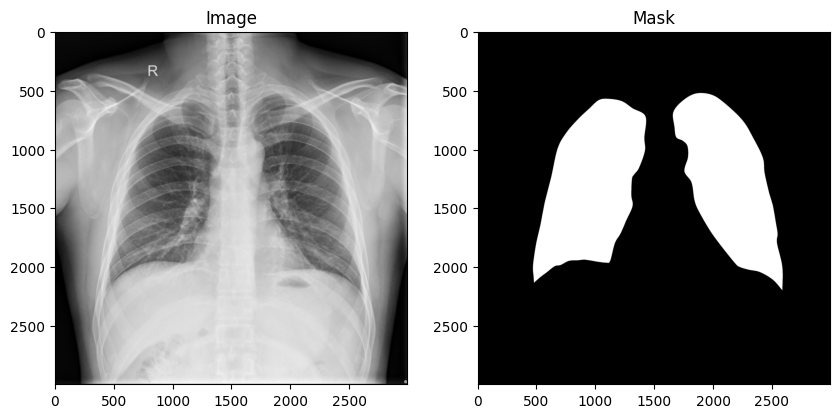

In [ ]:
im_ls, mask_ls = database_setup(path)

In [ ]:
# The dimensions and contents of the masks
# The mask has 0 and 255 as it's pixel values. I will convert it to 0 and 1, but as long integers

from skimage import io
import numpy as np

mask = io.imread(os.path.join(mask_path, mask_ls[0]))
print(f'Classes:{np.unique(mask)}')
print(f'Shape: {mask.shape}')
print(f'Data type: {mask.dtype}')
print(mask)

Classes:[  0 255]
Shape: (2995, 2993)
Data type: uint8
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# The dimensions and contents of the images

from skimage import io
import numpy as np

img = io.imread(os.path.join(im_path, im_ls[0]))

print(img.shape)
print(type(img))
print(img.dtype)
print(img)

(2995, 2993, 3)
<class 'numpy.ndarray'>
uint8
[[[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [56 56 56]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [57 57 57]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ...
  [55 55 55]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[19 19 19]
  [19 19 19]
  [20 20 20]
  ...
  [42 42 42]
  [ 0  0  0]
  [ 0  0  0]]

 [[19 19 19]
  [21 21 21]
  [21 21 21]
  ...
  [47 47 47]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


## Model definition

In [ ]:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=1, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

In [ ]:
def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
      nn.ReLU(inplace=True)
  )

In [ ]:
from torchvision.models import vgg16_bn
import torch.nn as nn

class UNetCat(nn.Module):

  def __init__(self, num_classes = 2):
    super().__init__()

    self.encoder = vgg16_bn(weights = 'DEFAULT').features

    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])

    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024) #increase channels. prepare for upsampling

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512 + 512, 512)
    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256 + 512, 256)
    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128 + 256, 128)
    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64 + 128, 64)
    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32 + 64, 32)

    self.conv11 = nn.Conv2d(32, num_classes, kernel_size = 1)

  def forward(self, x):

    # input is (3, 224, 224)
    # output is (64, 224, 224)
    block1 = self.block1(x)

    #output is (128, 112, 112)
    block2 = self.block2(block1)

    #output (256, 56, 56)
    block3 = self.block3(block2)

    #output (512, 28, 28)
    block4 = self.block4(block3)

    #output (512, 14, 14)
    block5 = self.block5(block4)

    #output (512, 7, 7)
    bottleneck = self.bottleneck(block5)

    #ouput (1024, 7, 7)
    x = self.conv_bottleneck(bottleneck)

    # output is (512, 14, 14)
    x = self.up_conv6(x)
    # output (512 + 512, 14, 14)
    x = torch.cat([x, block5], dim = 1) # we concatenate along the channels (i.e stack the features)
    # output is (512, 14, 14)
    x = self.conv6(x)

    # output (256, 28, 28)
    x = self.up_conv7(x)

    # output (256 + 512, 28, 28)
    x = torch.cat([x, block4], dim = 1)
    # output (256, 28, 28)
    x = self.conv7(x)

    # output (128, 56, 56)
    x = self.up_conv8(x)
    # output (128 + 256, 56, 56)
    x = torch.cat([x, block3], dim = 1)
    # output (128, 56, 56)
    x = self.conv8(x)

    # output (64, 112, 112)
    x = self.up_conv9(x)
    # output (64 + 128, 112, 112)
    x = torch.cat([x, block2], dim = 1)
    # output (64, 112, 112)
    x = self.conv9(x)

    # output (64, 224, 224)
    x = self.up_conv10(x)
    # output (64 + 64, 224, 224)
    x = torch.cat([x, block1], dim = 1)
    # output (32, 224, 224)
    x = self.conv10(x)

    # output (n_classes, 224, 224)
    x = self.conv11(x)

    return x

# PART 2: UNET 1

## Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

from skimage import io
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, root_dir):
    self.transforms_img = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    self.transforms_mask = T.Resize((224, 224))

    self.im_dir = os.path.join(root_dir, 'images')
    self.mask_dir = os.path.join(root_dir, 'masks')

    self.im_ls = sorted(os.listdir(self.im_dir))
    self.mask_ls = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.im_ls)

  def __getitem__(self, idx):

    # extract the path of images
    im_path = os.path.join(self.im_dir, self.im_ls[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_ls[idx])

    image = PIL.Image.open(im_path).convert('RGB')
    mask = PIL.Image.open(mask_path)

    #apply transforms
    image = self.transforms_img(image)
    mask = self.transforms_mask(mask)

    #mask is a PIL Image. Convert it to numpy, then to tensor
    #since we removed the ToTensor transform and left only the resize, we divide the mask by 255 to normalize it between 0 and 1
    mask = torch.tensor(np.array(mask)/255).long() # has to be a long tensor

    # no need of this since we do not have ToTensor for the masks
    # mask = mask.squeeze(0) # mask should be 2 dimension. ToTensor makes it have a channel dimension

    return image, mask

In [ ]:
# from torchvision import transforms as T
# import PIL
# import torch

# trans = T.Resize((224, 224))

# mask = PIL.Image.open(os.path.join(mask_path, mask_ls[0]))
# mask = trans(mask)

# mask = torch.tensor(np.array(mask)/255).long()

# mask.shape
# mask.unique()

Train set length: 563


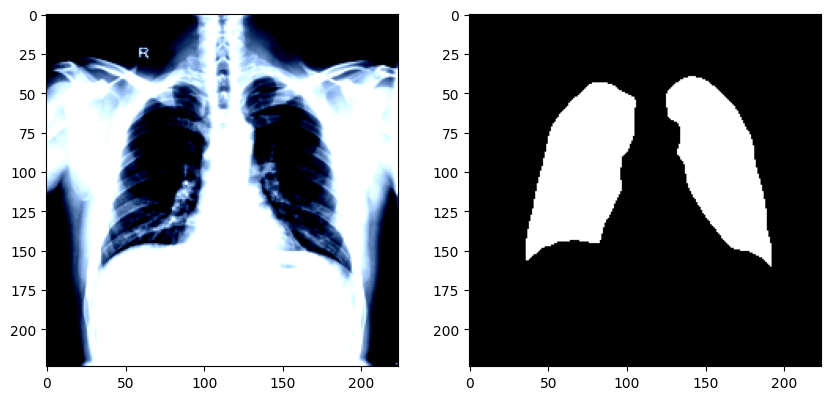

In [ ]:
# Confirmation if our custom dataset pipeline is working

train_td = CustomDataset('train')

print(f'Train set length: {len(train_td)}')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(train_td[0][0].permute(1, 2, 0));
ax[1].imshow(train_td[0][1], cmap = 'gray');

In [ ]:
test_td = CustomDataset('test')
val_td = CustomDataset('val')

print(len(train_td))
print(len(test_td))
print(len(val_td))

563
70
71


## Training

In [ ]:
from torch.utils.data import DataLoader
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNetCat(num_classes=2)

train_td = CustomDataset('train')
val_td = CustomDataset('val')
test_td = CustomDataset('test')

train_dl = DataLoader(train_td, batch_size=64, shuffle=True)
val_dl = DataLoader(val_td, batch_size=75) #75 is because the val and test sets have 70 images
test_dl = DataLoader(test_td, batch_size = 75)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
save_path = 'best_seg_project_unet.pth'

history = train_segmentation_model(model, train_dl, val_dl, optimizer, loss_fn, save_path, epochs=25, device='cuda')

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:06<00:00, 89.2MB/s]


Saved model at epoch 1 with Val Loss: 0.5015
Epoch: [1/25]	 Train Loss: 0.4884	 Val Loss: 0.5015	 Val Pixel Acc: 0.9417
Saved model at epoch 2 with Val Loss: 0.3500
Epoch: [2/25]	 Train Loss: 0.2744	 Val Loss: 0.3500	 Val Pixel Acc: 0.9742
Saved model at epoch 3 with Val Loss: 0.2648
Epoch: [3/25]	 Train Loss: 0.2382	 Val Loss: 0.2648	 Val Pixel Acc: 0.9737
Epoch: [4/25]	 Train Loss: 0.2097	 Val Loss: 0.2889	 Val Pixel Acc: 0.9225
Epoch: [5/25]	 Train Loss: 0.1865	 Val Loss: 0.2879	 Val Pixel Acc: 0.9094
Epoch: [6/25]	 Train Loss: 0.1661	 Val Loss: 0.3039	 Val Pixel Acc: 0.8912
Saved model at epoch 7 with Val Loss: 0.2142
Epoch: [7/25]	 Train Loss: 0.1499	 Val Loss: 0.2142	 Val Pixel Acc: 0.9369
Epoch: [8/25]	 Train Loss: 0.1356	 Val Loss: 0.2915	 Val Pixel Acc: 0.8915
Epoch: [9/25]	 Train Loss: 0.1230	 Val Loss: 0.2339	 Val Pixel Acc: 0.9214
Epoch: [10/25]	 Train Loss: 0.1124	 Val Loss: 0.3884	 Val Pixel Acc: 0.8469
Epoch: [11/25]	 Train Loss: 0.1026	 Val Loss: 0.3754	 Val Pixel Acc: 

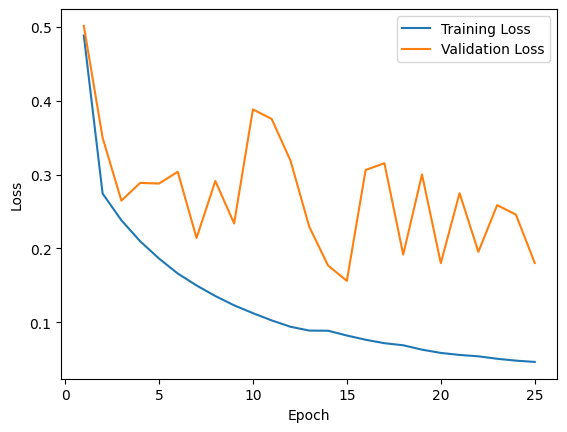

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Loss']) + 1)
plt.plot(x, history['Training']['Loss'], label='Training Loss')
plt.plot(x, history['Validation']['Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

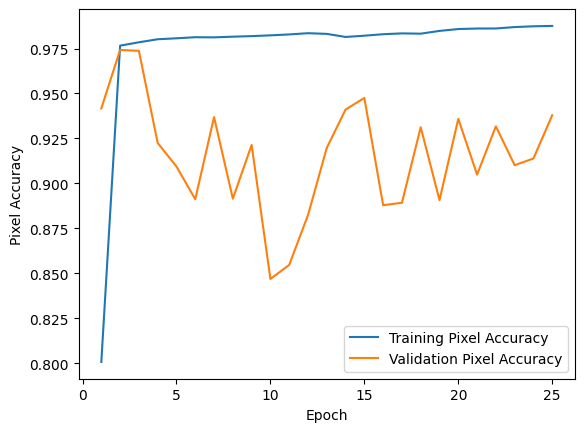

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Pixel Accuracy']) + 1)
plt.plot(x, history['Training']['Pixel Accuracy'], label='Training Pixel Accuracy')
plt.plot(x, history['Validation']['Pixel Accuracy'], label='Validation Pixel Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show();

## Load model for few predictions

In [ ]:
model = UNetCat(num_classes=2)

model_dic = torch.load('best_seg_project_unet.pth') #load the model's saved state dictionary
model.load_state_dict(model_dic)

model.to(device)

In [ ]:
# predicting the mask for an image

img = test_td[0][0]
mask = test_td[0][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

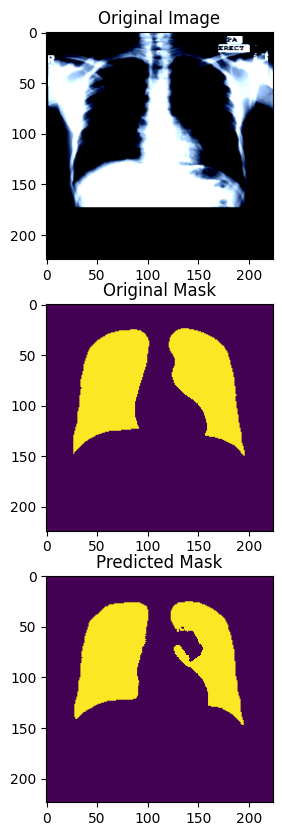

In [ ]:
# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

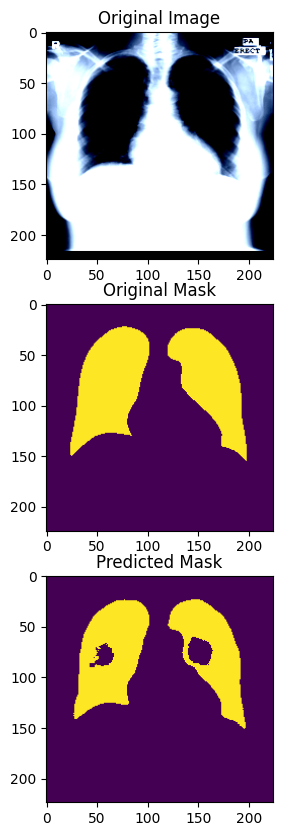

In [ ]:
# predicting the mask for an image

img = test_td[1][0]
mask = test_td[1][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

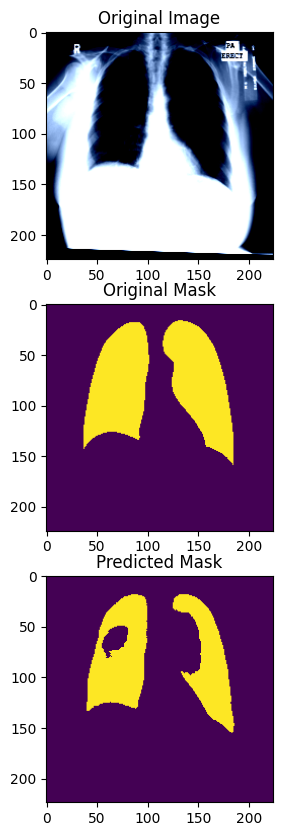

In [ ]:
# predicting the mask for an image

img = test_td[2][0]
mask = test_td[2][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

## Test set Evaluation

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def predict_segmentation(load_path, test_data_loader, num_classes, device='cpu'):
    """
    Predicts segmentation masks using a trained model.

    Args:
        load_path (str): Path to the saved model state dictionary.
        test_data_loader (DataLoader): DataLoader for the test set.
        img_size (tuple): Size of the input images (H, W).
        num_classes (int): Number of classes for segmentation.
        device (str): Device to run prediction on ('cpu' or 'cuda').

    Returns:
        tuple: (all_predictions, all_targets, accuracy)
            - all_predictions: List or Tensor of predicted masks.
            - all_targets: List or Tensor of ground truth masks.
            - accuracy: Pixel-wise accuracy on the test set.
    """

    # 1. Instantiate the model architecture
    # We need to recreate the model structure before loading weights
    # model = get_model(img_size=img_size, num_classes=num_classes)

    # 2. Load the state dictionary
    # Use map_location to handle loading GPU weights on CPU if needed
    state_dict = torch.load(load_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    correct_pixels = 0
    total_pixels = 0

    # We'll store results in CPU lists to avoid GPU OOM for large datasets
    all_predictions = []
    all_targets = []

    print("Starting prediction...")

    with torch.no_grad():
        for batch, targets in test_data_loader:
            inputs = batch.to(device)
            targets = targets.to(device).long()

            # Handle channel dimension in target if present (B, 1, H, W) -> (B, H, W)
            # if targets.dim() == 4:
            #     targets = targets.squeeze(1)

            # Forward pass
            # Output shape: (Batch, Num_Classes, Height, Width)
            output = model(inputs)

            # Get predicted class indices: (Batch, Height, Width)
            preds = output.argmax(dim=1)

            # Calculate batch statistics
            correct_pixels += (preds == targets).sum().item()
            total_pixels += targets.numel()

            # Store results
            # Move to CPU to save GPU memory
            all_predictions.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Calculate global pixel accuracy
    accuracy = correct_pixels / total_pixels
    print(f'Test set pixel accuracy: {accuracy:.4f}')

    # Concatenate all batches into single tensors
    # Final shapes: (Total_Samples, Height, Width)
    combo_predictions = torch.cat(all_predictions, dim=0)
    combo_targets = torch.cat(all_targets, dim=0)

    return combo_predictions, combo_targets, accuracy

# Example Usage (commented out)
if __name__ == "__main__":

    preds, targets, acc = predict_segmentation(
        load_path="best_seg_project_unet.pth",
        test_data_loader=test_dl,
        num_classes=2,
        device="cuda"
    )

Starting prediction...
Test set pixel accuracy: 0.9451


# PART 3: UNET 2

Continues from the previous model, but adds more data augmentation and uses early stopping

## Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
import os
import PIL
from skimage import io
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, root_dir, val = False):

    self.val = val

    self.joint_transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p = 0.5),
        T.RandomRotation(degrees = 10),
    ])

    self.im_transforms = T.Compose([
        T.ColorJitter(brightness = 0.2, contrast = 0.2),
        T.ToDtype(torch.float32, scale = True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    self.val_im_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToDtype(torch.float32, scale = True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    self.im_dir = os.path.join(root_dir, 'images')
    self.mask_dir = os.path.join(root_dir, 'masks')

    self.im_ls = sorted(os.listdir(self.im_dir))
    self.mask_ls = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.im_ls)

  def __getitem__(self, idx):

    # extract the path of images
    im_path = os.path.join(self.im_dir, self.im_ls[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_ls[idx])

    image = PIL.Image.open(im_path).convert('RGB')
    mask = PIL.Image.open(mask_path)

    image = tv_tensors.Image(image)
    mask = tv_tensors.Mask(mask)

    if self.val == True:
      image = self.val_im_transforms(image)
      mask = T.Resize((224, 224))(mask)

    else:
      image, mask = self.joint_transforms(image, mask)
      image = self.im_transforms(image)

    #since we removed the ToTensor transform and left only the resize, we divide the mask by 255 to normalize it between 0 and 1
    # mask = torch.tensor(np.array(mask)/255).long() # has to be a long tensor
    mask = (mask)/255.long() # tv_tensor already makes the mask as a tensor so the code above is redundant!

    # no need of this since we do not have ToTensor for the masks
    mask = mask.squeeze(0) # mask should be 2 dimension. tv_tensor makes it have a channel dimension (1, 224, 224)

    return image, mask

Train set length: 563


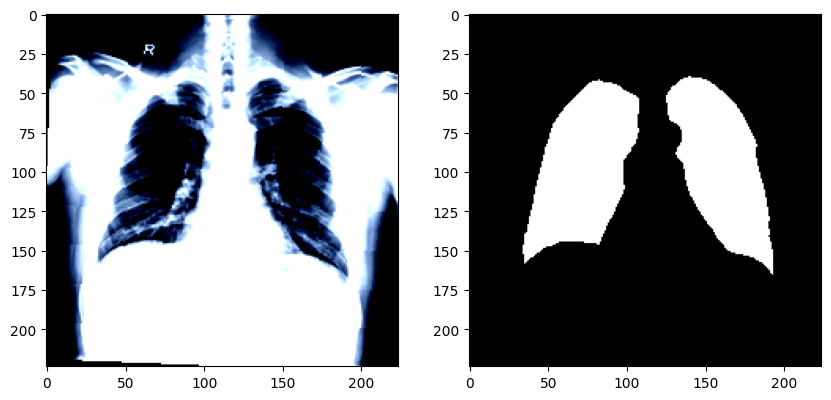

In [ ]:
# Confirmation if our custom dataset pipeline is working

train_td = CustomDataset('train')

print(f'Train set length: {len(train_td)}')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(train_td[0][0].permute(1, 2, 0));
ax[1].imshow(train_td[0][1], cmap = 'gray');

In [ ]:
test_td = CustomDataset('test', val = True)
val_td = CustomDataset('val', val = True)

print(len(train_td))
print(len(test_td))
print(len(val_td))

563
70
71


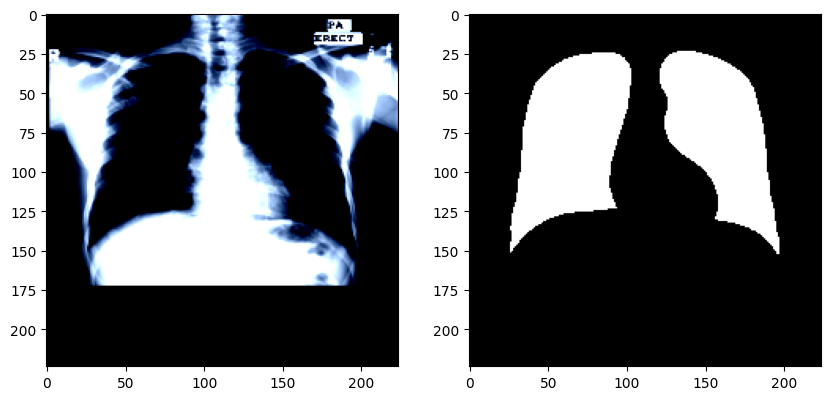

In [ ]:
# Confirmation if our custom dataset pipeline is working

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(test_td[0][0].permute(1, 2, 0));
ax[1].imshow(test_td[0][1], cmap = 'gray');

## Load model weights to continue training

In [ ]:
import os
path_model = '/content/drive/MyDrive/MSc Data Science/Thesis/Codes/segmentation'

model = UNetCat(num_classes=2)

model.load_state_dict(torch.load(os.path.join(path_model, 'best_seg_project_unet_1.pth')))

<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_td = CustomDataset('train')
val_td = CustomDataset('val', val = True)
test_td = CustomDataset('test', val = True)

train_dl = DataLoader(train_td, batch_size=32, shuffle=True)
val_dl = DataLoader(val_td, batch_size=38) #38 is because the val and test sets have 70 images
test_dl = DataLoader(test_td, batch_size = 38)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
save_path = os.path.join(path_model, 'best_seg_project_unet_augment.pth')

history = train_segmentation_model_es(model, train_dl, val_dl, optimizer, loss_fn, save_path, patience = 5, epochs=15, device='cuda')

Saved model at epoch 1 with Val Loss: 0.3284
Epoch: [1/15]	 Train Loss: 0.0918	 Val Loss: 0.3284	 Val Pixel Acc: 0.8858
Saved model at epoch 2 with Val Loss: 0.2303
Epoch: [2/15]	 Train Loss: 0.0711	 Val Loss: 0.2303	 Val Pixel Acc: 0.9158
Saved model at epoch 3 with Val Loss: 0.2153
Epoch: [3/15]	 Train Loss: 0.0640	 Val Loss: 0.2153	 Val Pixel Acc: 0.9179
Epoch: [4/15]	 Train Loss: 0.0589	 Val Loss: 0.2164	 Val Pixel Acc: 0.9197
Saved model at epoch 5 with Val Loss: 0.2119
Epoch: [5/15]	 Train Loss: 0.0572	 Val Loss: 0.2119	 Val Pixel Acc: 0.9208
Epoch: [6/15]	 Train Loss: 0.0557	 Val Loss: 0.2215	 Val Pixel Acc: 0.9202
Epoch: [7/15]	 Train Loss: 0.0554	 Val Loss: 0.2489	 Val Pixel Acc: 0.9169
Epoch: [8/15]	 Train Loss: 0.0529	 Val Loss: 0.2747	 Val Pixel Acc: 0.9050
Saved model at epoch 9 with Val Loss: 0.1842
Epoch: [9/15]	 Train Loss: 0.0521	 Val Loss: 0.1842	 Val Pixel Acc: 0.9301
Epoch: [10/15]	 Train Loss: 0.0522	 Val Loss: 0.2244	 Val Pixel Acc: 0.9144
Saved model at epoch 11 

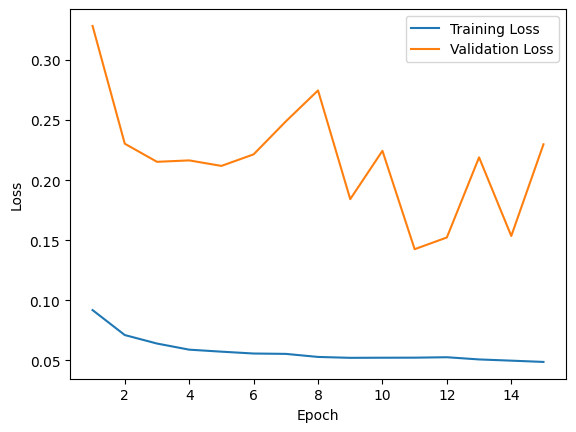

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Loss']) + 1)
plt.plot(x, history['Training']['Loss'], label='Training Loss')
plt.plot(x, history['Validation']['Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

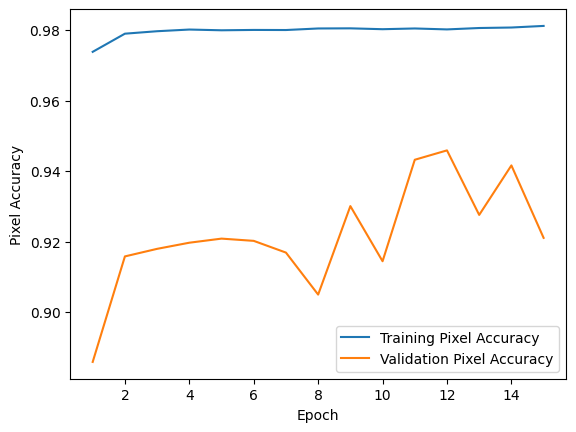

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Pixel Accuracy']) + 1)
plt.plot(x, history['Training']['Pixel Accuracy'], label='Training Pixel Accuracy')
plt.plot(x, history['Validation']['Pixel Accuracy'], label='Validation Pixel Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show();

## Load model for few predictions

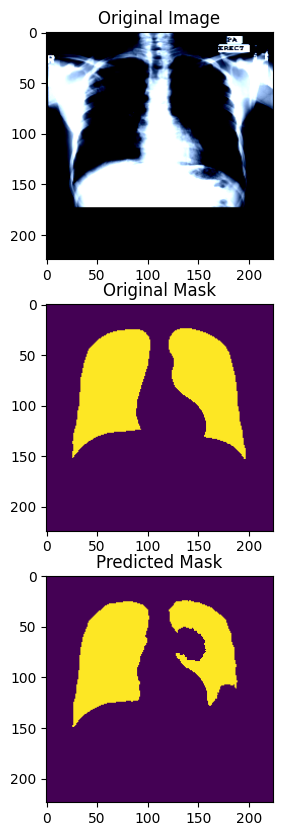

In [ ]:
model = UNetCat(num_classes=2)

model.load_state_dict(torch.load(os.path.join(path_model, 'best_seg_project_unet_augment.pth')))

model.to(device)

# predicting the mask for an image

img = test_td[0][0]
mask = test_td[0][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

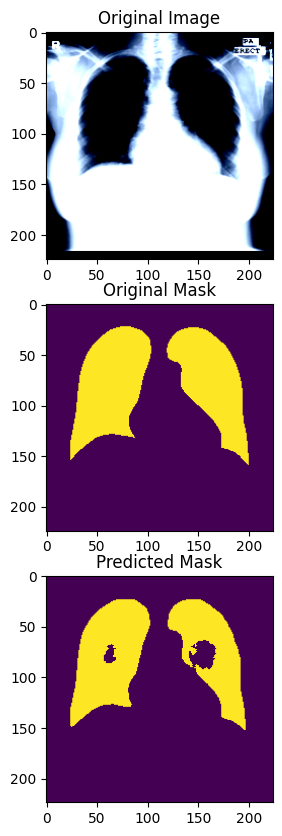

In [ ]:
# predicting the mask for an image

img = test_td[1][0]
mask = test_td[1][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

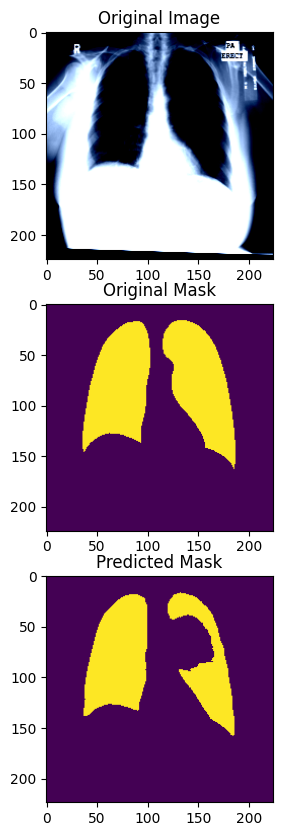

In [ ]:
# predicting the mask for an image

img = test_td[2][0]
mask = test_td[2][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

## Test set Evaluation

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os

def predict_segmentation(load_path, test_data_loader, num_classes, device='cpu'):
    """
    Predicts segmentation masks using a trained model.

    Args:
        load_path (str): Path to the saved model state dictionary.
        test_data_loader (DataLoader): DataLoader for the test set.
        img_size (tuple): Size of the input images (H, W).
        num_classes (int): Number of classes for segmentation.
        device (str): Device to run prediction on ('cpu' or 'cuda').

    Returns:
        tuple: (all_predictions, all_targets, accuracy)
            - all_predictions: List or Tensor of predicted masks.
            - all_targets: List or Tensor of ground truth masks.
            - accuracy: Pixel-wise accuracy on the test set.
    """

    # 1. Instantiate the model architecture
    # We need to recreate the model structure before loading weights
    # model = get_model(img_size=img_size, num_classes=num_classes)

    # 2. Load the state dictionary
    # Use map_location to handle loading GPU weights on CPU if needed
    state_dict = torch.load(load_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    correct_pixels = 0
    total_pixels = 0

    # We'll store results in CPU lists to avoid GPU OOM for large datasets
    all_predictions = []
    all_targets = []

    print("Starting prediction...")

    with torch.no_grad():
        for batch, targets in test_data_loader:
            inputs = batch.to(device)
            targets = targets.to(device).long()

            # Handle channel dimension in target if present (B, 1, H, W) -> (B, H, W)
            # if targets.dim() == 4:
            #     targets = targets.squeeze(1)

            # Forward pass
            # Output shape: (Batch, Num_Classes, Height, Width)
            output = model(inputs)

            # Get predicted class indices: (Batch, Height, Width)
            preds = output.argmax(dim=1)

            # Calculate batch statistics
            correct_pixels += (preds == targets).sum().item()
            total_pixels += targets.numel()

            # Store results
            # Move to CPU to save GPU memory
            all_predictions.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Calculate global pixel accuracy
    accuracy = correct_pixels / total_pixels
    print(f'Test set pixel accuracy: {accuracy:.4f}')

    # Concatenate all batches into single tensors
    # Final shapes: (Total_Samples, Height, Width)
    combo_predictions = torch.cat(all_predictions, dim=0)
    combo_targets = torch.cat(all_targets, dim=0)

    return combo_predictions, combo_targets, accuracy

# Example Usage (commented out)
if __name__ == "__main__":

    preds, targets, acc = predict_segmentation(
        load_path=os.path.join(path_model, 'best_seg_project_unet_augment.pth'),
        test_data_loader=test_dl,
        num_classes=2,
        device="cuda"
    )

Starting prediction...
Test set pixel accuracy: 0.9391


In [ ]:
!pip install torchmetrics

## Dice and IOU score for test set

In [ ]:
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore

# dice from class defined
dice = DiceScore(num_classes = 2,
                #  average = 'macro'
                 )

dice_score = dice(preds, targets)

print(f"Dice Score: {dice_score.item():.4f}")

# jacard score
jaccard = JaccardIndex(task="multiclass", num_classes=2,
                      #  average = 'macro'
                       )

iou = jaccard(preds, targets)

print(f"Jaccard Score: {iou.item():.4f}")

Dice Score: 0.8539
Jaccard Score: 0.8407


# PART 4: UNET 3

In this part, we continued training the model from part 3, but shifted to using a combination of dice loss and cross entropy loss. There was improvements.

## Dice Loss

I generated this with AI and did not get the time to understand it and modify any unnecessary complex lines.

In [ ]:
import torch.nn.functional as F

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: (B, Num_Classes, H, W) -> raw logits
        # targets: (B, H, W) -> class indices (0, 1)

        # 1. Apply Softmax to get probabilities (0 to 1)
        inputs = F.softmax(inputs, dim=1)

        # 2. One-hot encode the targets to match inputs shape
        # targets becomes (B, Num_Classes, H, W)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        # 3. Calculate Dice for the "Lung" class (Index 1)
        # We focus on the lung class because background is easy and dominates the score
        input_lung = inputs[:, 1, :, :]
        target_lung = targets_one_hot[:, 1, :, :]

        # Flatten for calculation
        input_flat = input_lung.contiguous().view(-1)
        target_flat = target_lung.contiguous().view(-1)

        # Intersection
        intersection = (input_flat * target_flat).sum()

        # Dice Formula
        dice = (2. * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)

        # Loss is 1 - Dice Score
        return 1 - dice

## Training

In [ ]:
from torch.utils.data import DataLoader
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_td = CustomDataset('train')
val_td = CustomDataset('val', val = True)
test_td = CustomDataset('test', val = True)

train_dl = DataLoader(train_td, batch_size=32, shuffle=True)
val_dl = DataLoader(val_td, batch_size=38) #38 is because the val and test sets have 70 images
test_dl = DataLoader(test_td, batch_size = 38)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn_ce = nn.CrossEntropyLoss()
save_path = os.path.join(path_model, 'best_seg_project_unet_augment_dice.pth')

history = train_segmentation_model_es_dice(model, train_dl, val_dl, optimizer, loss_fn_ce, save_path, patience = 5, epochs=15, device='cuda')

Saved model at epoch 1 with Val Loss: 0.6260
Epoch: [1/15]	 Train Loss: 0.2055	 Val Loss: 0.6260	 Val Pixel Acc: 0.8921
Saved model at epoch 2 with Val Loss: 0.5205
Epoch: [2/15]	 Train Loss: 0.1579	 Val Loss: 0.5205	 Val Pixel Acc: 0.9100
Saved model at epoch 3 with Val Loss: 0.2596
Epoch: [3/15]	 Train Loss: 0.1399	 Val Loss: 0.2596	 Val Pixel Acc: 0.9539
Epoch: [4/15]	 Train Loss: 0.1303	 Val Loss: 0.3384	 Val Pixel Acc: 0.9388
Epoch: [5/15]	 Train Loss: 0.1195	 Val Loss: 0.4275	 Val Pixel Acc: 0.9228
Saved model at epoch 6 with Val Loss: 0.1224
Epoch: [6/15]	 Train Loss: 0.1149	 Val Loss: 0.1224	 Val Pixel Acc: 0.9778
Epoch: [7/15]	 Train Loss: 0.1123	 Val Loss: 0.1851	 Val Pixel Acc: 0.9654
Epoch: [8/15]	 Train Loss: 0.1092	 Val Loss: 0.4289	 Val Pixel Acc: 0.9221
Epoch: [9/15]	 Train Loss: 0.1078	 Val Loss: 0.2078	 Val Pixel Acc: 0.9610
Epoch: [10/15]	 Train Loss: 0.1059	 Val Loss: 0.2303	 Val Pixel Acc: 0.9585
Saved model at epoch 11 with Val Loss: 0.1015
Epoch: [11/15]	 Train L

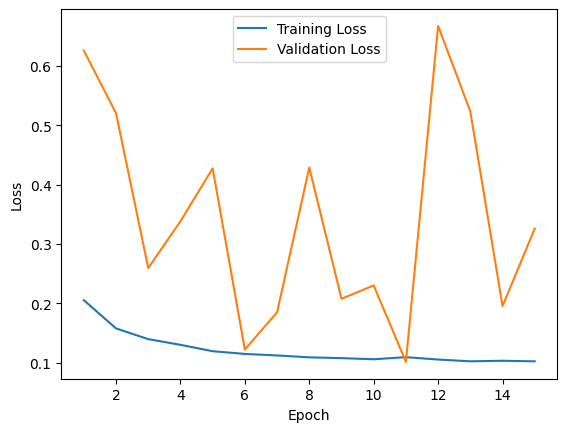

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Loss']) + 1)
plt.plot(x, history['Training']['Loss'], label='Training Loss')
plt.plot(x, history['Validation']['Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

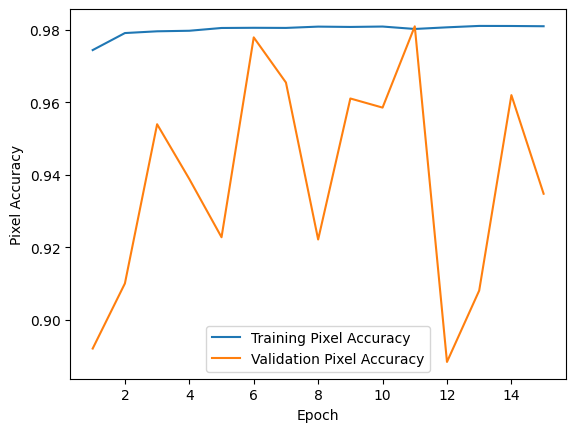

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Pixel Accuracy']) + 1)
plt.plot(x, history['Training']['Pixel Accuracy'], label='Training Pixel Accuracy')
plt.plot(x, history['Validation']['Pixel Accuracy'], label='Validation Pixel Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show();

## Load model for few predictions

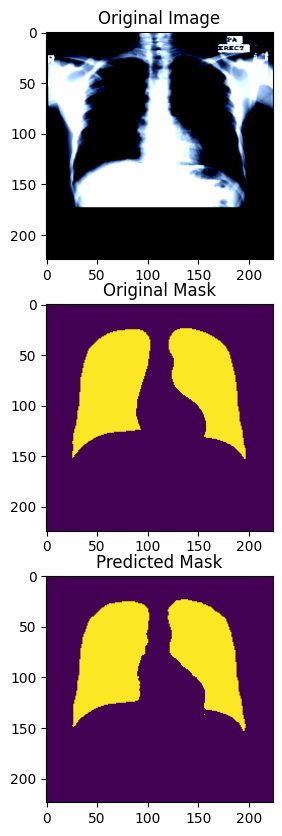

In [ ]:
model = UNetCat(num_classes=2)

model.load_state_dict(torch.load(os.path.join(path_model, 'best_seg_project_unet_augment_dice.pth')))

model.to(device)

# predicting the mask for an image

img = test_td[0][0]
mask = test_td[0][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

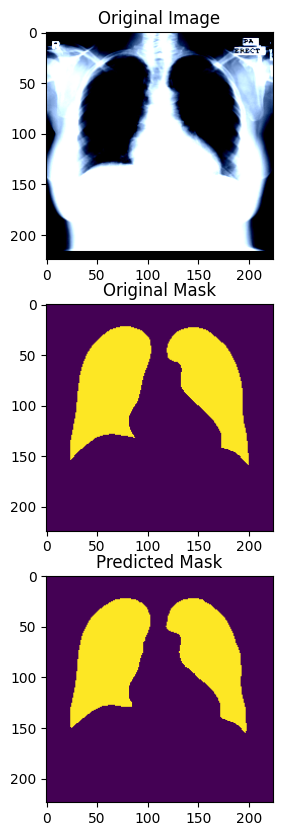

In [ ]:
# predicting the mask for an image

img = test_td[1][0]
mask = test_td[1][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

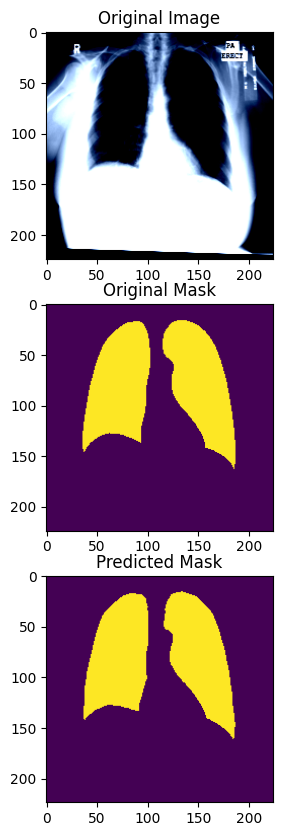

In [ ]:
# predicting the mask for an image

img = test_td[2][0]
mask = test_td[2][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

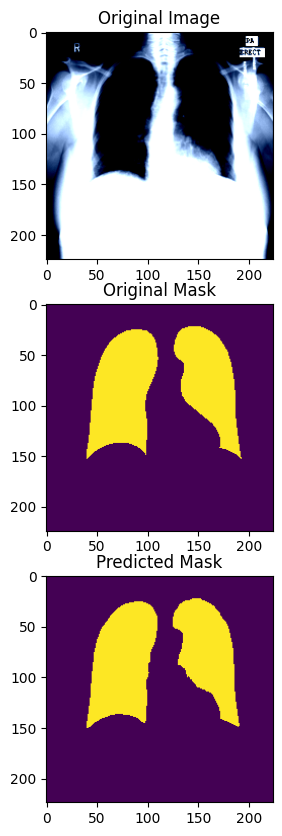

In [ ]:
# predicting the mask for an image

img = test_td[3][0]
mask = test_td[3][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

## Test set evaluation

In [ ]:
preds, targets, acc = predict_segmentation(
        load_path=os.path.join(path_model, 'best_seg_project_unet_augment_dice.pth'),
        test_data_loader=test_dl,
        num_classes=2,
        device="cuda"
    )

print(f'Test set pixel accuracy: {acc:.4f}')

# this generalized dice score is not the dice score i needed.

dice_metric = GeneralizedDiceScore(num_classes  = 2)
dice_score = dice_metric(preds, targets)

print(f"Dice Score: {dice_score.item():.4f}")

Starting prediction...
Test set pixel accuracy: 0.9813
Test set pixel accuracy: 0.9813
Dice Score: 0.6615


In [ ]:
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore

# dice from class defined
dice = DiceScore(num_classes = 2,
                #  average = 'macro'
                 )
dice_score = dice(preds, targets)

print(f"Dice Score: {dice_score.item():.4f}")

# jacard score
jaccard = JaccardIndex(task="multiclass", num_classes=2,
                      #  average = 'macro'
                       )
iou = jaccard(preds, targets)

print(f"Jaccard Score: {iou.item():.4f}")

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


Dice Score: 0.8539
Jaccard Score: 0.8407


# PART 5: UNET 4

In this part, we started training from scratch and implemented
- Added random_affine transform
- LR Scheduler

## Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
import os
import PIL
from skimage import io
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, root_dir, val = False):

    self.val = val

    self.joint_transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p = 0.5),
        T.RandomAffine(degrees = 10, #patient is not always straight
                       translate = (0.1, 0.1), #shift it vertically and horizontally from the center
                       scale = (0.9, 1.1)), # controls the size of the lungs
    ])

    self.im_transforms = T.Compose([
        T.ColorJitter(brightness = 0.2, contrast = 0.2),
        T.ToDtype(torch.float32, scale = True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    self.val_im_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToDtype(torch.float32, scale = True),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    self.im_dir = os.path.join(root_dir, 'images')
    self.mask_dir = os.path.join(root_dir, 'masks')

    self.im_ls = sorted(os.listdir(self.im_dir))
    self.mask_ls = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.im_ls)

  def __getitem__(self, idx):

    # extract the path of images
    im_path = os.path.join(self.im_dir, self.im_ls[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_ls[idx])

    image = PIL.Image.open(im_path).convert('RGB')
    mask = PIL.Image.open(mask_path)

    image = tv_tensors.Image(image)
    mask = tv_tensors.Mask(mask)

    if self.val == True:
      image = self.val_im_transforms(image)
      mask = T.Resize((224, 224))(mask)

    else:
      image, mask = self.joint_transforms(image, mask)
      image = self.im_transforms(image)

    #since we removed the ToTensor transform and left only the resize, we divide the mask by 255 to normalize it between 0 and 1
    # mask = torch.tensor(np.array(mask)/255).long() # has to be a long tensor
    mask = (mask/255).long() # tv_tensor already makes the mask as a tensor so the code above is redundant!

    # no need of this since we do not have ToTensor for the masks
    mask = mask.squeeze(0) # mask should be 2 dimension. tv_tensor makes it have a channel dimension (1, 224, 224)

    return image, mask

Train set length: 563


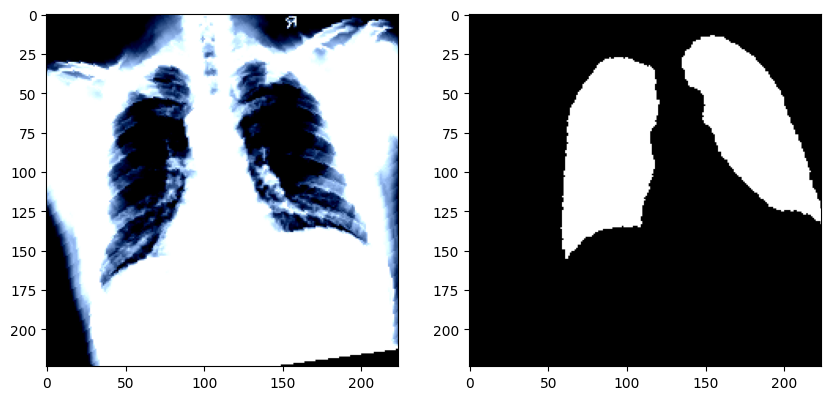

In [ ]:
# Confirmation if our custom dataset pipeline is working

train_td = CustomDataset('train')

print(f'Train set length: {len(train_td)}')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(train_td[0][0].permute(1, 2, 0));
ax[1].imshow(train_td[0][1], cmap = 'gray');

In [ ]:
test_td = CustomDataset('test', val = True)
val_td = CustomDataset('val', val = True)

print(len(train_td))
print(len(test_td))
print(len(val_td))

563
70
71


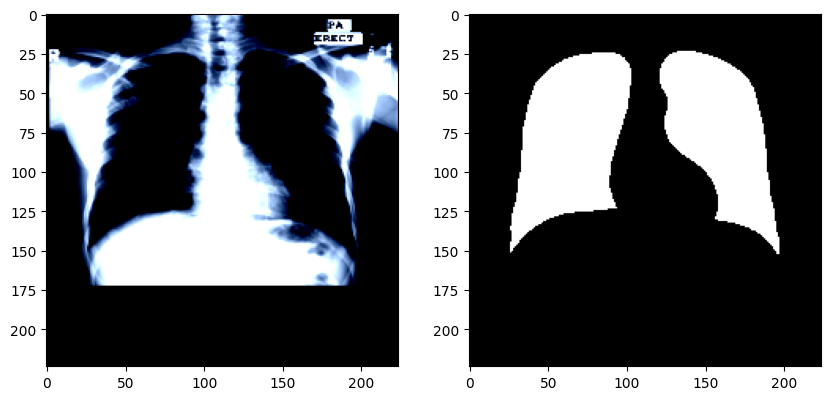

In [ ]:
# Confirmation if our custom dataset pipeline is working

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(test_td[0][0].permute(1, 2, 0));
ax[1].imshow(test_td[0][1], cmap = 'gray');

### run 1

In [ ]:
from torch.utils.data import DataLoader
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(num_classes=2)
path_model = '/content/drive/MyDrive/MSc Data Science/Thesis/Codes/segmentation'

train_td = CustomDataset('train')
val_td = CustomDataset('val', val = True)
test_td = CustomDataset('test', val = True)

train_dl = DataLoader(train_td, batch_size=32, shuffle=True)
val_dl = DataLoader(val_td, batch_size=38) #38 is because the val and test sets have 70 images
test_dl = DataLoader(test_td, batch_size = 38)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn_ce = nn.CrossEntropyLoss()

save_path = os.path.join(path_model, 'best_seg_project_unet_improve_2.pth')

history = train_es_lr_dice(model, train_dl, val_dl, optimizer, loss_fn_ce, save_path, patience_es = 5, epochs=15, device='cuda')

Saved model at epoch 1 with Val Loss: 0.7607
Epoch: [1/15]	 Train Loss: 0.7244	 Dice: 0.6172	 Val Loss: 0.7607	 Val Acc: 0.9623	 Val Dice: 0.5846
Saved model at epoch 2 with Val Loss: 0.3800
Epoch: [2/15]	 Train Loss: 0.4175	 Dice: 0.7623	 Val Loss: 0.3800	 Val Acc: 0.9672	 Val Dice: 0.7804
Epoch: [3/15]	 Train Loss: 0.3013	 Dice: 0.8262	 Val Loss: 0.4421	 Val Acc: 0.9335	 Val Dice: 0.7610
Saved model at epoch 4 with Val Loss: 0.2362
Epoch: [4/15]	 Train Loss: 0.2346	 Dice: 0.8652	 Val Loss: 0.2362	 Val Acc: 0.9720	 Val Dice: 0.8656
Epoch: [5/15]	 Train Loss: 0.1933	 Dice: 0.8918	 Val Loss: 0.8519	 Val Acc: 0.8512	 Val Dice: 0.5796
Saved model at epoch 6 with Val Loss: 0.1822
Epoch: [6/15]	 Train Loss: 0.1668	 Dice: 0.9088	 Val Loss: 0.1822	 Val Acc: 0.9731	 Val Dice: 0.9025
Epoch: [7/15]	 Train Loss: 0.1519	 Dice: 0.9190	 Val Loss: 0.1987	 Val Acc: 0.9666	 Val Dice: 0.8941
Saved model at epoch 8 with Val Loss: 0.1149
Epoch: [8/15]	 Train Loss: 0.1421	 Dice: 0.9250	 Val Loss: 0.1149	 V

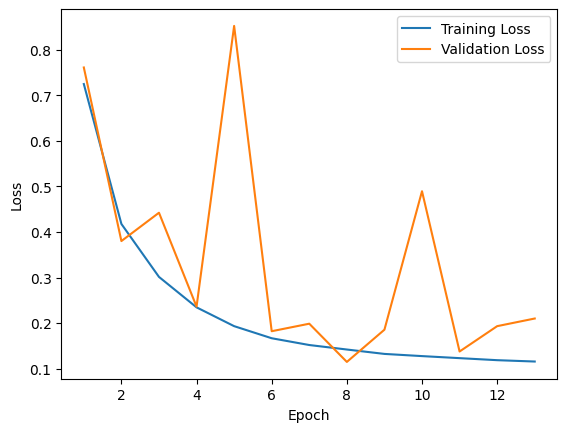

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Loss']) + 1)
plt.plot(x, history['Training']['Loss'], label='Training Loss')
plt.plot(x, history['Validation']['Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

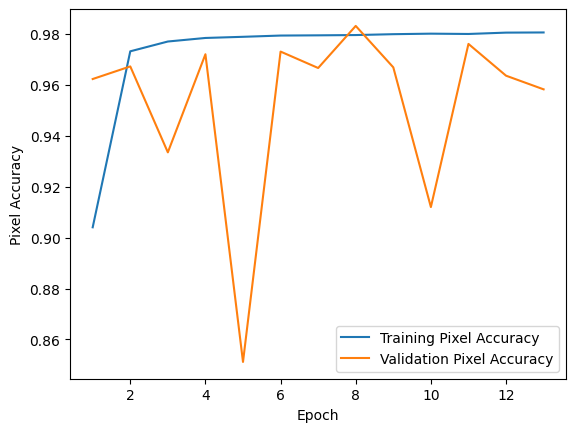

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Pixel Accuracy']) + 1)
plt.plot(x, history['Training']['Pixel Accuracy'], label='Training Pixel Accuracy')
plt.plot(x, history['Validation']['Pixel Accuracy'], label='Validation Pixel Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show();

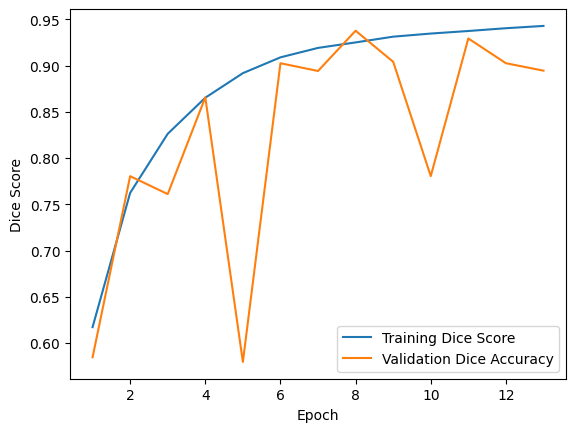

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, len(history['Training']['Dice Score']) + 1)
plt.plot(x, history['Training']['Dice Score'], label='Training Dice Score')
plt.plot(x, history['Validation']['Dice Score'], label='Validation Dice Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.show();

## Load model for few predictions

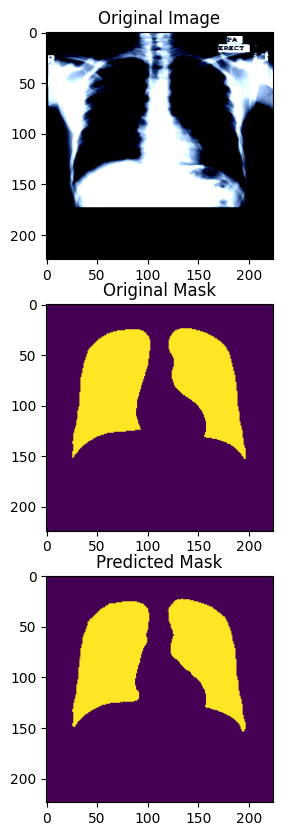

In [ ]:
model = UNet(num_classes=2)

model.load_state_dict(torch.load(os.path.join(path_model, 'best_seg_project_unet_improve_2.pth')))

model.to(device)

# predicting the mask for an image

img = test_td[0][0]
mask = test_td[0][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

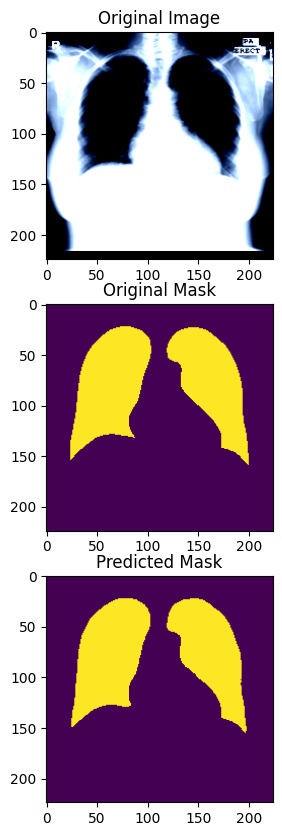

In [ ]:
# predicting the mask for an image

img = test_td[1][0]
mask = test_td[1][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

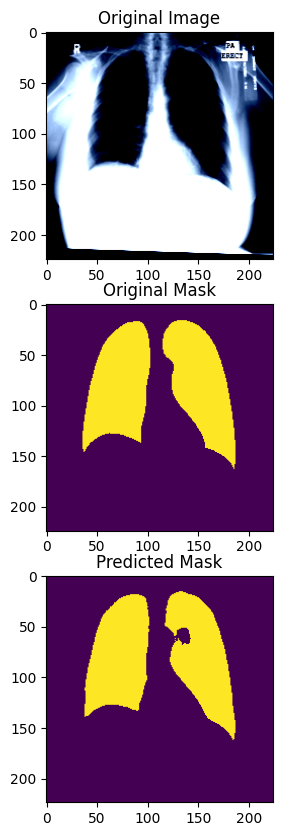

In [ ]:
# predicting the mask for an image

img = test_td[2][0]
mask = test_td[2][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

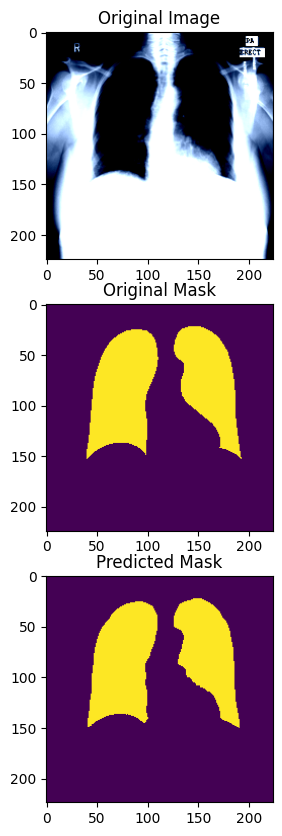

In [ ]:
# predicting the mask for an image

img = test_td[3][0]
mask = test_td[3][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

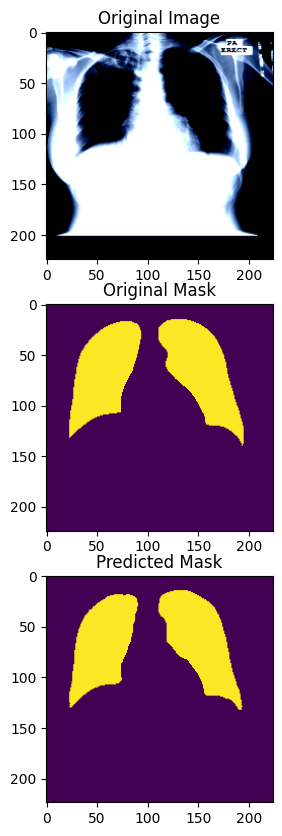

In [ ]:
# predicting the mask for an image

img = test_td[4][0]
mask = test_td[4][1]

model.eval() #forgot this.. it is important to avoid some layers used only for training
# the output here is logits with a shape of 1, 3, 224, 224

output_mask = model(img.unsqueeze(0).to(device)) #unsqueeze adds a batch dim which is expected

# index of the class with maximum logits
pred_mask = output_mask.argmax(dim=1).squeeze(0).cpu()

# plotting

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

ax[0].imshow(img.permute(1, 2, 0));
ax[0].set_title('Original Image')

ax[1].imshow(mask);
ax[1].set_title('Original Mask');

ax[2].imshow(pred_mask);
ax[2].set_title('Predicted Mask');

## Test set Evaluation

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import os

def predict_segmentation(load_path, test_data_loader, num_classes, device='cpu'):
    """
    Predicts segmentation masks using a trained model.

    Args:
        load_path (str): Path to the saved model state dictionary.
        test_data_loader (DataLoader): DataLoader for the test set.
        img_size (tuple): Size of the input images (H, W).
        num_classes (int): Number of classes for segmentation.
        device (str): Device to run prediction on ('cpu' or 'cuda').

    Returns:
        tuple: (all_predictions, all_targets, accuracy)
            - all_predictions: List or Tensor of predicted masks.
            - all_targets: List or Tensor of ground truth masks.
            - accuracy: Pixel-wise accuracy on the test set.
    """

    # 1. Instantiate the model architecture
    # We need to recreate the model structure before loading weights
    # model = get_model(img_size=img_size, num_classes=num_classes)

    # 2. Load the state dictionary
    # Use map_location to handle loading GPU weights on CPU if needed
    state_dict = torch.load(load_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    correct_pixels = 0
    total_pixels = 0

    # We'll store results in CPU lists to avoid GPU OOM for large datasets
    all_predictions = []
    all_targets = []

    print("Starting prediction...")

    with torch.no_grad():
        for batch, targets in test_data_loader:
            inputs = batch.to(device)
            targets = targets.to(device).long()

            # Handle channel dimension in target if present (B, 1, H, W) -> (B, H, W)
            # if targets.dim() == 4:
            #     targets = targets.squeeze(1)

            # Forward pass
            # Output shape: (Batch, Num_Classes, Height, Width)
            output = model(inputs)

            # Get predicted class indices: (Batch, Height, Width)
            preds = output.argmax(dim=1)

            # Calculate batch statistics
            correct_pixels += (preds == targets).sum().item()
            total_pixels += targets.numel()

            # Store results
            # Move to CPU to save GPU memory
            all_predictions.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Calculate global pixel accuracy
    accuracy = correct_pixels / total_pixels
    print(f'Test set pixel accuracy: {accuracy:.4f}')

    # Concatenate all batches into single tensors
    # Final shapes: (Total_Samples, Height, Width)
    combo_predictions = torch.cat(all_predictions, dim=0)
    combo_targets = torch.cat(all_targets, dim=0)

    return combo_predictions, combo_targets, accuracy

In [ ]:
!pip install torchmetrics

## Dice score for test set

In [ ]:
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore

save_path = os.path.join(path_model, 'best_seg_project_unet_improve_2.pth')

preds, targets, acc = predict_segmentation(
        load_path=save_path,
        test_data_loader=test_dl,
        num_classes=2,
        device="cuda"
    )

# dice from class defined
dice = DiceScore(num_classes = 2,
                #  average = 'macro'
                 )

dice_score = dice(preds, targets)

print(f"Dice Score: {dice_score.item():.4f}")

# jacard score
jaccard = JaccardIndex(task="multiclass", num_classes=2,
                      #  average = 'macro'
                       )

iou = jaccard(preds, targets)

print(f"Jaccard Score: {iou.item():.4f}")

Starting prediction...
Test set pixel accuracy: 0.9816
Dice Score: 0.9599


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


Jaccard Score: 0.9515
